In [0]:
#XGBOOST

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import cross_val_score
import xgboost as xgb


%matplotlib inline

In [0]:
file='https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv'

In [0]:
#Charger les données

data=pd.read_csv(file)
data.head()


#Créer la timeline
timeline=data.apply(lambda x: datetime.strptime(x['GOLD_Time'],"%Y-%m-%d"),axis=1)[1:]


#Ajouter une variable "nombre de jours depuis le début"
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

my_min=min(data['GOLD_Time'])
data['day_to_start']=data.apply(lambda x: days_between(x['GOLD_Time'],my_min),axis=1)


#créer un df pour conserver la timeline
time_df=pd.DataFrame({'date':timeline,'day_to_start':data['day_to_start'][1:]})

#Supprimer la colonne temporelle de data
data=data.drop('GOLD_Time',axis=1)

In [0]:
#Remplacer les na par la valeur précédente non nulle

In [0]:
data.ffill(inplace=True)  

In [0]:
#Créer target et features

In [0]:
target=data.BTC_Close
target=target[1:]  #Retirer la première valeur

features=data.drop('BTC_Close',axis=1)
features=features[:-1]  #Retirer la dernières ligne

In [0]:
#Normalisation

scaler=MinMaxScaler()

#On conserve le day_to_date normalisé dans time_df (day_to_date est la dernière colonne)

feat_norm=pd.DataFrame(scaler.fit_transform(features))
feat_norm.columns=features.columns

In [0]:
#Création X_train et X_test

In [0]:
X_train,X_test,y_train,y_test=train_test_split(feat_norm,target,test_size=0.2)

In [0]:
dnorm=xgb.DMatrix(feat_norm, label=target)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


'XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='rmse', gamma=0,
       gpu_id=-1, importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)'

Nous allons effectuer un premier essai, avec 10 rounds.

In [0]:
xg1=xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10,eval_metric='rmse',n_estimators = 50)#objective='reg:squarederror'
xg1.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
             n_estimators=50, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [0]:
ypred1=xg1.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, ypred1))
print("RMSE_baseline: %f" % (rmse))

RMSE_baseline: 162.193012


Nous vérifions la stabilité du modèle avec une cross-validation:

In [0]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dnorm, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

Le modèle est plutôt bon. Il y a a une légère variation dans les résultats. Il n'y a pas d'overfitting.

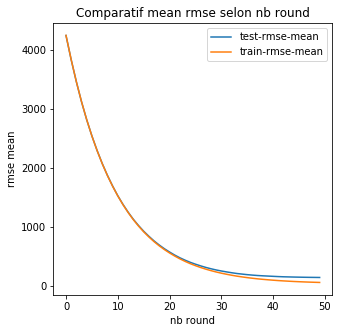

In [0]:
fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(111)

ax1.plot(cv_results["test-rmse-mean"],label='test-rmse-mean')
ax1.plot(cv_results["train-rmse-mean"],label='train-rmse-mean')
ax1.set_ylabel('rmse mean')
ax1.set_xlabel('nb round')
ax1.legend(loc='best')
ax1.set_title('Comparatif mean rmse selon nb round');

Les cinquante rounds semblent corrects. Nous allons tester 100 rounds pour voir le résultat:

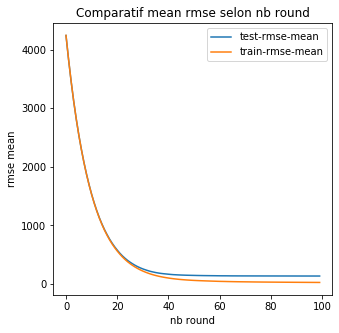

In [0]:
cv_results2 = xgb.cv(dtrain=dnorm, params=params, nfold=5,
                    num_boost_round=100,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(111)

ax1.plot(cv_results2["test-rmse-mean"],label='test-rmse-mean')
ax1.plot(cv_results2["train-rmse-mean"],label='train-rmse-mean')
ax1.set_ylabel('rmse mean')
ax1.set_xlabel('nb round')
ax1.legend(loc='best')
ax1.set_title('Comparatif mean rmse selon nb round');

Il n'y a quasiment aucune amélioration après 60 rounds. Nous allons conserver ce paramètre.

Nous allons tenter d'améliorer le modèle en modifiant les hyperparamètres:

In [0]:
from xgboost import XGBRegressor

estimator = XGBRegressor(
    objective= 'reg:squarederror',
    nthread=4,
    seed=42,
    n_estimators = 60
)


params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
parameters = {
    'max_depth': range (2, 6, 1),
    'colsample_bytree': np.arange(0.1, 0.4,0.1),
    'alpha': np.arange(1,10,1),
    'learning_rate': np.arange(0.01, 0.1,0.01)
}

In [0]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 5,
    cv = 5,
    verbose=True
)

In [0]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   44.0s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.0min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  8.9min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 12.3min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 16.1min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 25.5min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 30.6min
[Parallel(n_jobs=5)]: Done 6480 out of 6480 | elapsed: 33.1min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) i

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=60, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, re...
                                    scale_pos_weight=1, seed=42, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'alpha': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'colsample_bytree': array([0.1, 0.2, 0.3, 0.4]),

grid_search.fit(X_train, y_train)

Nous pouvons observer les meilleurs estimateurs:

In [0]:
grid_search.best_estimator_

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.09, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=60,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=1, verbosity=1)

In [0]:
results = pd.DataFrame(grid_search.cv_results_)

In [0]:
ypred_rs=grid_search.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test, ypred_rs))
diff_rs=abs(y_test-ypred_rs)
print("RMSE_grid_search: %f" % (rmse2))
print("Nous passons donc d'une rmse de ",round(rmse,2)," avant le paramètrage des hyperparamètres à une rsme de ",round(rmse2,2)," après paramètrage des hyperparamètres." )

RMSE_grid_search: 130.446414
Nous passons donc d'une rmse de  162.19  avant le paramètrage des hyperparamètres à une rsme de  130.45  après paramètrage des hyperparamètres.


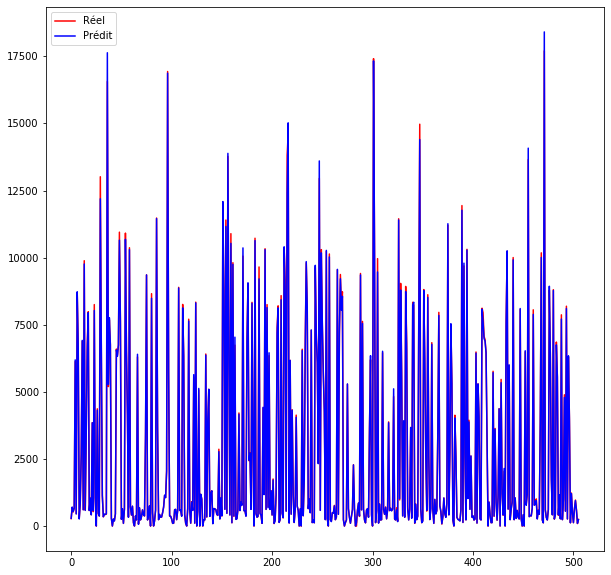

In [0]:
x_axis=range(0,len(y_test))

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.plot(x_axis,y_test,color='red',label='Réel')
ax.plot(x_axis,ypred_rs,color='blue',label='Prédit')
ax.legend(loc='best');

In [0]:
# Nous allons créer des X_train et X_test temporels, afin de mieux visualiser la prédiction.

2529

In [0]:
import math
l=math.ceil(len(features)*96/100)

X_train_temp=feat_norm.sort_values('day_to_start')[0:l]
X_test_temp=feat_norm.sort_values('day_to_start')[l+1:]
y_train_temp=target[::-1][0:l]
y_test_temp=target[::-1][l+1:]



In [0]:
grid_search2 = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 5,
    cv = 5,
    verbose=True
)


grid_search2.fit(X_train_temp, y_train_temp)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   45.5s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  4.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  6.8min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  9.8min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 13.6min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed: 17.8min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4990 tasks      | elapsed: 28.3min
[Parallel(n_jobs=5)]: Done 6040 tasks      | elapsed: 34.1min
[Parallel(n_jobs=5)]: Done 6480 out of 6480 | elapsed: 37.0min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) i

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=60, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, re...
                                    scale_pos_weight=1, seed=42, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'alpha': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'colsample_bytree': array([0.1, 0.2, 0.3, 0.4]),

In [0]:
ypred_temp=grid_search2.predict(X_test_temp)
rmse_temp = np.sqrt(mean_squared_error(y_test_temp, ypred_temp))

In [0]:
rmse_temp

160.6074110382255

In [0]:
diff_rs_temp=abs(y_test_temp- ypred_temp)

In [0]:
diff_rs.describe()

count     506.000000
mean       48.998231
std       121.013973
min         0.027420
25%         3.080116
50%         7.963326
75%        41.486389
max      1421.691406
Name: BTC_Close, dtype: float64

In [0]:
diff_rs_temp.describe()

count    100.000000
mean     121.559165
std      105.495990
min        2.180664
25%       48.227539
50%       90.682861
75%      171.248291
max      744.910156
Name: BTC_Close, dtype: float64

Le résultat est évidemment beaucoup moins bon, mais plus visualisable.

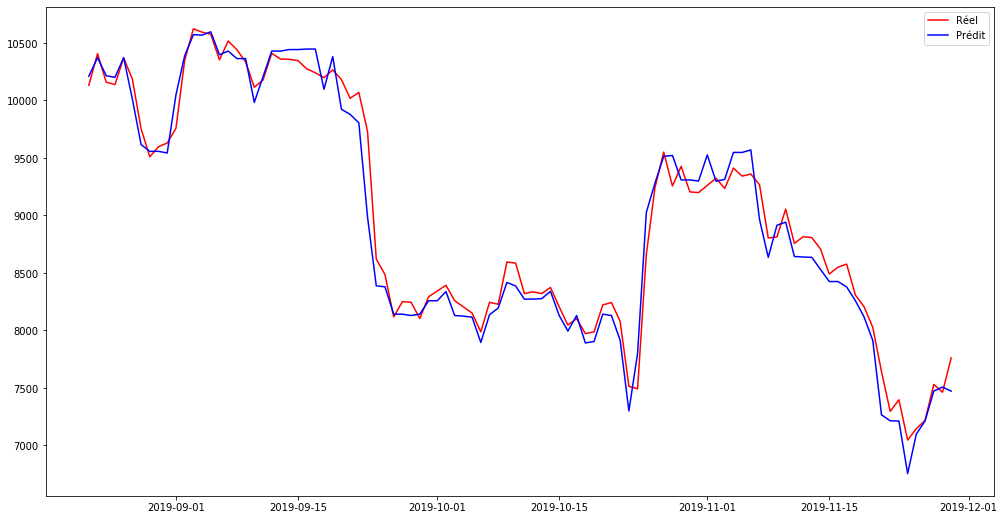

In [0]:
x_axis=timeline[::-1][l+1:]

fig=plt.figure(figsize=(17,9))
ax=fig.add_subplot(111)
ax.plot(x_axis,y_test_temp,color='red',label='Réel')
ax.plot(x_axis,ypred_temp,color='blue',label='Prédit')
ax.legend(loc='best');

Afin de mieux comprendre la différence de comportement entre le "normal" et le "réalisé", nous pouvons regarder la distribution du pourcentage de différence entre le prédit et le réalisé.

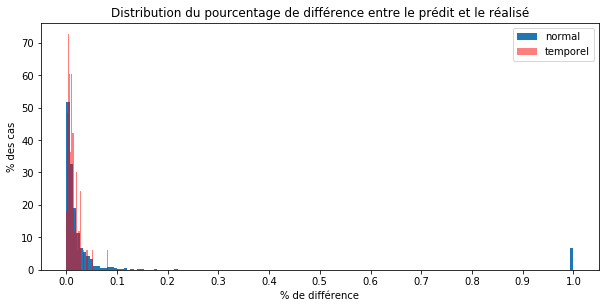

In [0]:
i=abs((y_test-ypred_rs)/ypred_rs)
i_temp=abs((y_test_temp-ypred_temp)/ypred_temp)

fig=plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
#ax2 = plt.subplot(212)

ax1.hist(i,bins=150,density=True,label='normal');
ax1.set_xticks(np.arange(0,1.1,0.1))
#ax1.set_title('% de différence prédit/réalisé - normal')
ax1.hist(i_temp,bins=50,density=True,color='red',alpha=0.5,label='temporel')
ax1.legend(loc='best')
ax1.title.set_text('Distribution du pourcentage de différence entre le prédit et le réalisé')
ax1.set_xlabel('% de différence')
ax1.set_ylabel('% des cas');
#ax2.set_xticks(np.arange(0,1.1,0.1));
#ax2.set_title('% de différence prédit/réalisé - temporel');


